# Natural Language Processing with Disaster Tweets

https://www.kaggle.com/c/nlp-getting-started/data

In [1]:
import numpy as np
import os
import pandas as pd


data_fp = os.path.join(os.getcwd(), "data")
train_fp = os.path.join(data_fp, "train.csv")
train_full = pd.read_csv(train_fp, encoding="utf-8")
test_fp = os.path.join(data_fp, "test.csv")
test = pd.read_csv(test_fp, encoding="utf-8")

print(f"Train: {train_full.shape}")
print(f"Test:  {test.shape}")

train_full.head()

Train: (7613, 5)
Test:  (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Kaggle supplies the test set (without target labels), so we will submit our final predictions there to get the ultimate measure of model performance. We separate 20% of the training data as a validation set.

In [2]:
# Shuffle the index in case there are patterns in the order of the training data:
np.random.seed(42)
shuffled_ix = list(train_full.index)
np.random.shuffle(shuffled_ix)
cutoff = int(len(shuffled_ix)*0.8)
train = train_full.loc[shuffled_ix[:cutoff]].copy()
validation = train_full.loc[shuffled_ix[cutoff:]].copy()

## Base Model

We use CountVectorizer and BernoulliNB to create a baseline model, and get benchmark score against the validation set.

Note that the target labels are binary outcomes, so they comrpise a Bernoulli distribution where $p \approx 0.43$. Therefore accuracy is the chosen metric of performance, since there isn't a huge class imbalance.

Bernoulli distribution, p = 0.430
Mean accuracy on 5-fold cross validation = 0.802
Validation accuracy = 0.793


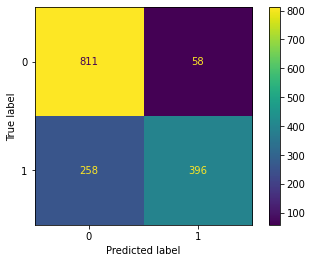

In [3]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import BernoulliNB


cv = CountVectorizer()
cv.fit(train["text"])
train_arr = cv.transform(train["text"])
train_labels = train["target"]
print(f"Bernoulli distribution, p = {train_labels.mean():.3f}")
model = BernoulliNB()
crossval = cross_validate(model, train_arr, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.3f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
val_arr = cv.transform(validation["text"])
val_labels = validation["target"]
val_score = best_estimator.score(val_arr, val_labels)
print(f"Validation accuracy = {val_score:.3f}")
cm = plot_confusion_matrix(best_estimator, val_arr, val_labels)

## Approach

To improve performance we explore 2 different avenues:

1. How the text data is represented. Specifically we use word embeddings.
2. What type of model is used to learn the relationships between embeddings and the target feature.

Specifically for part 1, the following word embedding schemes are explored:

1. Word2Vec - pretrained
2. Word2Vec - corpus trained

For part 2, based on the results of <a href="https://github.com/MIDS-W207/coursework/blob/master/Readings/Week%2008/An%20Empirical%20Comparison%20of%20Supervised%20Learning%20Algorithms.pdf">this</a> paper comparing the performance of classifiers, we try out the following 3 classifiers:

1. Boosted Trees
2. Support Vector Machines
3. Neural Networks

## Pre-Processing

Since we are using Word Embeddings, we'll need to standardize the format of the input tweets. From the creators of the dataset there is a <a href="https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb">Ruby script</a>, which has been converted to <a href="https://www.kaggle.com/amackcrane/python-version-of-glove-twitter-preprocess-script">Python</a> by a Kaggle user. The below method is adapted from this Python version, with some additional changes to improve the number of input words which can be embedded. Some of these changes include:

1. Removing most punctuation entirely. The original Kaggle script leaves a lot of punctation untouched, so that for example the quoted word `'something'` would be included as a separate feature to the unquoted word `something`. We make the assumption that such differences in punctuation of features are unlikely to be significant in identifying disaster tweets.
2. Fixing a couple of bugs with the way whitespace was added around certain punctuation marks, such as `.,`
3. Add spaces around inserted tags such as ` <number> `

Making the above changes to the preprocessor we increase the number of input words which are found in the embedding vocabulary from ~75% to nearly 90%.

One interesting decision in the preprocessing script is to remove tagged twitter usernames (i.e. strings starting with `@`), since you might expect that this could provide some useful information in trying to predict the nature of the tweets. For example, a tweet tagging a local fire department might be much more likely to be a disaster related tweet. However on searching the word embedding features for well known Twitter usernames (e.g. `@realdonaldtrump`) we find that they are not present, so this seems to accord with the processing done for the Glove word embeddings.

In [4]:

import string
import sys
import regex as re

FLAGS = re.MULTILINE | re.DOTALL


punctuation = string.punctuation.replace("#", "")
punctuation = punctuation.replace("<", "")
punctuation = punctuation.replace(">", "")


def _hashtag(text):
    """Parse hashtags in tweets.
    
    For hashtags with words in title case, splits into separate words, e.g.
        #BigFire -> <hashtag> Big Fire 
        
    For all caps hashtags converts to lowercase, e.g.
        #OMG -> <hashtag> omg
    """
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = f" <hashtag> {hashtag_body.lower()} <allcaps> "
    else:
        result = " ".join([" <hashtag> "] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result


def _allcaps(text):
    """Convert all-caps words to lowercase and add allcaps tag."""
    text = text.group()
    return text.lower() + " <allcaps> "


def tokenize(text):
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    # Remove URLS:
    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", " <url> ")
    
    # Remove usernames:
    text = re_sub(r"@\w+", " <user> ")
    
    # Tag smiley faces :-) sad faces :-( etc.
    eyes, nose = r"[8:=;]", r"['`\-]?"
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), " <smile> ")
    text = re_sub(r"{}{}p+".format(eyes, nose), " <lolface> ")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), " <sadface> ")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), " <neutralface> ")
    text = re_sub(r"<3"," <heart> ")

    # Add whitespace around /
    text = re_sub(r"/"," / ")
    
    # Tag numbers:
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", " <number> ")
    
    # Tag hastags and separate hashtag words:
    text = re_sub(r"#\w+", _hashtag)
    
    # Remove and tag repetitions of question marks, exclamations:
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat> ")
    
    # Tag elongated sequences of the same letter (3+ occurences), e.g. "AAAAAAA"
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong> ")
    
    # Put whitespace around punctuation, then remove:
    text = re_sub(r"([a-zA-Z<>()])([{}])".format(punctuation), r"\1 \2")
    text = re_sub(r"([{}])([a-zA-Z<>()])".format(punctuation), r"\1 \2")
    text = re.sub("[%s]" % re.escape(punctuation), "", text)

    # Tag all caps words:
    text = re_sub(r" ([A-Z]){2,} ", _allcaps)
    
    return " ".join(text.lower().split())


In [5]:
# Example with lots of weird features:
text = "#BigFire on #MountEverest #OMG, !! /where are police 'some' punctuation! 3now 44 @police"
tokenize(text)

'<hashtag> <elong> big fire on <hashtag> <elong> mount everest <hashtag> omg <allcaps> <repeat> where are police some punctuation <number> now <number> <user>'

In [6]:
# Example from the dataset:
example_tweet = train["text"][0]
print("Original Tweet:\n", f"  {example_tweet}\n")
print("Kaggle user script:\n", f"{tokenize(example_tweet)}\n")

Original Tweet:
   Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

Kaggle user script:
 our deeds are the reason of this <hashtag> earthquake may allah <allcaps> forgive us all



## Word Embeddings

We use word embeddings to convert each word to a $d$-length vector. Because the models we are using require a single vector input, we need a way to then convert the multiple word embeddings for a single tweet into one vector. Using the suggestion <a href="https://stats.stackexchange.com/a/239071/115143">here</a>, we try 2 approaches:

1. Take the simple average of the vectors for all words in the tweet (resulting in vector of length $d$).
2. Concatenate the coordinate-wise minimum and maximum values in each word vector (resulting in vector of length $2d$).

In [7]:

from gensim.models.keyedvectors import KeyedVectors
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from spellchecker import SpellChecker
import yaml


class WordEmbeddings:
    """Class to create word embeddings from input tweets, 
    including text pre-processing."""
    
    def __init__(self, X: pd.Series, embeddings: KeyedVectors, 
                 processor = tokenize, spellcheck: bool = True, 
                 idf_filter: float = 0.05, stop_words: list = None):
        """
        """
        # Save the raw input as a list:
        self.X_raw = X.tolist()
        
        # Apply the preprocessor function:
        X = X.map(processor).tolist()
        
        # Apply the spelling corrections:
        if spellcheck:
            corrections = self.correct_spellings([])
            corrected = list()
            for tweet in X:
                corrected.append(" ".join([corrections.get(w, w) for w in tweet.split()]))
            X = corrected
        
        # Apply IDF to remove common words in corpus:
        if idf_filter is not None:
            vect = TfidfVectorizer(
                input="content", encoding="utf-8", lowercase=True, 
                analyzer="word", ngram_range=(1, 1), max_df=1.0, min_df=1
            )
            vect.fit(X)
            df = pd.DataFrame({"word": vect.get_feature_names(), "idf": vect.idf_})
            df.sort_values(by=["idf"], ascending=True, inplace=True)
            number = int(len(df) * idf_filter)
            drop_words = set(df.iloc[:number]["word"].tolist())
            filtered = list()
            for tweet in X:
                filtered.append(" ".join(list(filter(lambda w: w not in drop_words, tweet.split()))))
            X = filtered
        
        # Drop stop words:
        if stop_words is not None:
            filtered = list()
            for tweet in X:
                filtered.append(" ".join(list(filter(lambda w: w not in stop_words, tweet.split()))))
            X = filtered

        self.X = X
        
        # Store the word embeddings scheme:
        self.embeddings = embeddings
        
        # Unique vocabulary of the embedding scheme:
        self.embeddings_vocab = set(embeddings.key_to_index)
        
        # Unique vocabulary of the inputs:
        self.X_vocab = {w for words in [s.split() for s in X] for w in words}
        
        # Unknown words in the input:
        self.unknown_words = self.X_vocab - self.embeddings_vocab

        # Common vocabulary between the input and the embeddings scheme:
        self.common_vocab = self.embeddings_vocab & self.X_vocab
        self.vocab_coverage = len(self.common_vocab) / len(self.X_vocab)
        print(f"{len(self.X_vocab):} processed input words, "\
              f"{len(self.common_vocab):} found in embeddings "\
              f"({self.vocab_coverage*100:.2f}%).")

        # Lookup table from words to their embeddings:
        self.embeddings_table = pd.DataFrame(embeddings[self.common_vocab], index=self.common_vocab).sort_index()
        
        # Iterate through input tweets removing unknown words, creating average/min/max embeddings:
        embedding_mu, embedding_max, embedding_min, clean_tweets = list(), list(), list(), list()
        for i, tweet in enumerate(self.X):
            
            # Remove unknown words:
            words = tweet.split()
            known_words = [w for w in words if w in self.common_vocab]
            clean_tweets.append(" ".join(known_words))
            
            # Calculate mean of all word embeddings in tweet:
            mean_array = self.embeddings_table.loc[known_words].mean().values
            embedding_mu.append(mean_array)
            
            # Calculate min/max of all word embeddings in tweet:
            max_array = self.embeddings_table.loc[known_words].max().values
            embedding_max.append(max_array)
            min_array = self.embeddings_table.loc[known_words].min().values
            embedding_min.append(min_array)
            
        # Arrays of final X datasets in word embedding formats:
        self.embedding_mu = pd.DataFrame(np.array(embedding_mu))
        self.embedding_min = np.array(embedding_min)
        self.embedding_max = np.array(embedding_max)
        self.embedding_minmax = pd.DataFrame(np.concatenate([self.embedding_min, self.embedding_max], axis=1))
        
    @property
    def embedding_chars(self):
        """Unique characters in the word embeddings."""
        return "".join(sorted(set([c for w in self.embeddings.index_to_key for c in w])))
    
    @staticmethod
    def correct_spellings(words: list):
        """Use pyspellchecker to save a dictionary of unknown words
        to corrected spellings, or just load presaved corrections. 
        See:
            https://github.com/barrust/pyspellchecker
        """
        fp = os.path.join(os.getcwd(), "spelling_corrections.yaml")
        if not os.path.exists(fp):
            corrections = dict()
            with open(fp, "w") as stream:
                yaml.safe_dump(corrections, stream)
        else:
            with open(fp, "r") as stream:
                corrections = yaml.safe_load(stream)
            if corrections is None:
                corrections = dict()
        to_correct = [w for w in words if w not in corrections]
        if to_correct:
            spell = SpellChecker()
            new = {w: spell.correction(w) for w in to_correct}
            corrections = {**corrections, **new}
            with open(fp, "w") as stream:
                yaml.safe_dump(corrections, stream)
            print(f"Saved {len(new):} spelling corrections to file.")
        return corrections


### Word2Vec

Using a pretrained Twitter Word2Vec model with ~1.2m word vocabulary:

In [8]:
from gensim import downloader


# Load the pretrained word embeddings (this takes a while):
glove_twitter = downloader.load("glove-twitter-200")
info = downloader.info()
print(info["models"]["glove-twitter-200"]["description"])

Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/).


In [9]:
# Use the WordEmbeddings class to apply embeddings to the training & validation data:
# train_we = WordEmbeddings(train["text"], glove_twitter, idf_filter=0.05)
# validation_we = WordEmbeddings(validation["text"], glove_twitter, idf_filter=0.05)
train_we = WordEmbeddings(train["text"], glove_twitter, idf_filter=None)
validation_we = WordEmbeddings(validation["text"], glove_twitter, idf_filter=None)

12145 processed input words, 11404 found in embeddings (93.90%).
5507 processed input words, 5141 found in embeddings (93.35%).


## Neural Network

Using TensorFlow to train model with "early stopping" to prevent over-fitting:

In [10]:

from sklearn.metrics import accuracy_score
import tensorflow as tf


class TfModel:
    
    def __init__(self, X_train: WordEmbeddings, y_train: pd.Series, 
                 X_val: WordEmbeddings, y_val: pd.Series, 
                 epochs: int = 500, patience: int = 5):
        """Implement a TensorFlow model on WordEmbeddings training and 
        validation data."""
        
        # Store model inputs:
        self.X_train, self.y_train = X_train, y_train
        self.X_val, self.y_val = X_val, y_val
                
        # Train separate models for different embeddings schemes:
        self.results, self.best_score, self.best_model = dict(), -np.inf, None
        for embeddings in ("embedding_mu", "embedding_minmax"):            
            print(f"Training {embeddings} model\n")
            
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(2)
            ])

            model.compile(
                optimizer="adam",
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"]
            )

            callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy", 
                mode="max", 
                min_delta=0.001,
                patience=patience, 
                restore_best_weights=True
            )
            
            X_train_df = getattr(X_train, embeddings)
            X_val_df = getattr(X_val, embeddings)
            history = model.fit(
                x=X_train_df,
                y=self.y_train,
                batch_size=512,
                callbacks=[callback],
                verbose=2,
                validation_data=(X_val_df, self.y_val),
                epochs=epochs,
            )

            # Use probabilities to make predictions on validation set:
            proba_model = tf.keras.Sequential([
                model, 
                tf.keras.layers.Softmax()
            ])
            train_proba_pred = proba_model.predict(X_train_df)
            val_proba_pred = proba_model.predict(X_val_df)
            train_pred = np.argmax(train_proba_pred, axis=1)
            val_pred = np.argmax(val_proba_pred, axis=1)
            
            # Store full results:
            results_data = {
                "model": model,
                "history": history,
                "proba_model": proba_model,
                "train_proba_pred": train_proba_pred,
                "val_proba_pred": val_proba_pred,
                "train_pred": train_pred,
                "val_pred": val_pred,
            }
            self.results[embeddings] = results_data
            
            # Score the model on overall accuracy on validation set:
            accuracy = accuracy_score(self.y_val, val_pred)
            if accuracy > self.best_score:
                self.best_score = accuracy
                self.best_model = embeddings 
    
    @property
    def inspect_train(self):
        df = pd.DataFrame({
            "raw_tweet": self.X_train.X_raw,
            "processed_tweet": self.X_train.X,
            "true_label": self.y_train.values,
            "prediction": self.results[self.best_model]["train_pred"]
        })
        return df

    @property
    def inspect_val(self):
        df = pd.DataFrame({
            "raw_tweet": self.X_val.X_raw,
            "processed_tweet": self.X_val.X,
            "true_label": self.y_val.values,
            "prediction": self.results[self.best_model]["val_pred"]
        })
        return df


In [17]:
tf_nn = TfModel(
    train_we, train_labels, validation_we, val_labels, epochs=500, patience=10
)

Training embedding_mu model

Epoch 1/500
12/12 - 0s - loss: 0.6134 - accuracy: 0.6732 - val_loss: 0.5442 - val_accuracy: 0.7380
Epoch 2/500
12/12 - 0s - loss: 0.5089 - accuracy: 0.7632 - val_loss: 0.4948 - val_accuracy: 0.7577
Epoch 3/500
12/12 - 0s - loss: 0.4637 - accuracy: 0.7903 - val_loss: 0.4714 - val_accuracy: 0.7728
Epoch 4/500
12/12 - 0s - loss: 0.4406 - accuracy: 0.8031 - val_loss: 0.4620 - val_accuracy: 0.7735
Epoch 5/500
12/12 - 0s - loss: 0.4258 - accuracy: 0.8125 - val_loss: 0.4585 - val_accuracy: 0.7827
Epoch 6/500
12/12 - 0s - loss: 0.4158 - accuracy: 0.8181 - val_loss: 0.4555 - val_accuracy: 0.7853
Epoch 7/500
12/12 - 0s - loss: 0.4074 - accuracy: 0.8259 - val_loss: 0.4539 - val_accuracy: 0.7840
Epoch 8/500
12/12 - 0s - loss: 0.4003 - accuracy: 0.8291 - val_loss: 0.4525 - val_accuracy: 0.7814
Epoch 9/500
12/12 - 0s - loss: 0.3948 - accuracy: 0.8287 - val_loss: 0.4525 - val_accuracy: 0.7932
Epoch 10/500
12/12 - 0s - loss: 0.3863 - accuracy: 0.8383 - val_loss: 0.4561 - v

In [18]:
tf_nn.best_score

0.7931713722915299

In [19]:
tf_nn.best_model

'embedding_mu'

Inspect some False Positives / False Negatives:

In [20]:
false_positives = tf_nn.inspect_val[
    (tf_nn.inspect_val["true_label"] == 0) & 
    (tf_nn.inspect_val["prediction"] == 1)
]
false_negatives = tf_nn.inspect_val[
    (tf_nn.inspect_val["true_label"] == 1) & 
    (tf_nn.inspect_val["prediction"] == 0)
]

In [21]:
pd.set_option("display.max_colwidth", 500)
false_positives

,raw_tweet,processed_tweet,true_label,prediction
6,Practice your families fire escape plan so everyone knows what to do in case of an emergency.,practice your families fire escape plan so everyone knows what to do in case of an emergency,0,1
8,ykelquiban: Breaking news! Unconfirmed! I just heard a loud bang nearby. in what appears to be a blast of wind from my neighbour's ass.,ykelquiban breaking news unconfirmed i just heard a loud bang nearby in what appears to be a blast of wind from my neighbour s ass,0,1
11,The Five Fatal Flaws in the Iran Deal https://t.co/ztfEAd8GId via @YouTube,the five fatal flaws in the iran deal <url> via <user>,0,1
39,@comcastcares hey it's happing again. Any trouble shooting steps for when this happens?,<user> hey it s happing again any trouble shooting steps for when this happens,0,1
43,cancel the fucking show. Evacuate MetLife https://t.co/SkQ8oUcM3R,cancel the fucking show evacuate metlife <url>,0,1
...,...,...,...,...
1478,EMS1: NY EMTs petition for $17 per hour Û÷minimum wageÛª http://t.co/4oa6SWlxmR #ems #paramedics #ambulance,ems <number> ny <allcaps> emts petition for <number> per hour û÷minimum wageûª <url> <hashtag> ems <hashtag> paramedics <hashtag> ambulance,0,1
1482,The Danger and Excitement of Underwater Cave Diving http://t.co/8c3fPloxcr http://t.co/cBGZ9xuN2k,the danger and excitement of underwater cave diving <url> <url>,0,1
1484,@CaraJDeIevingnc the bomb impact ratio hit beyond kyle js,<user> the bomb impact ratio hit beyond kyle js,0,1
1502,How many cars do those cyclists wreck going past scratching with pedals. They should be banned #c4news,how many cars do those cyclists wreck going past scratching with pedals they should be banned <hashtag> c <number> news,0,1


In [22]:
false_negatives

,raw_tweet,processed_tweet,true_label,prediction
5,@PyramidHead76 one good thing came out of watching the film. Was too traumatised to watch show so started Halt &amp; Catch Fire on Amazon. :D,<user> one good thing came out of watching the film was too traumatised to watch show so started halt amp catch fire on amazon <smile>,1,0
22,Gonna call up tomorrow with the aul 'emergency dental appointment' excuse just like the whole tooth falling out incident of last year,gonna call up tomorrow with the aul emergency dental appointment excuse just like the whole tooth falling out incident of last year,1,0
38,@TheEvilOlives It's the closest structure to the hypo centre that wasn't completely obliterated.,<user> it s the closest structure to the hypo centre that wasn t completely obliterated,1,0
55,oh yeah my ipod almost exploded last night i was using it while charging and shit was sparking akxbskdn almost died,oh yeah my ipod almost exploded last night i was using it while charging and shit was sparking akxbskdn almost died,1,0
72,Bigamist and his 'first' wife are charged in the deaths of his 'second' pregnant wife her child 8 her mothe... http://t.co/rTEuGB5Tnv,bigamist and his first wife are charged in the deaths of his second pregnant wife her child <number> her mothe <repeat> <url>,1,0
...,...,...,...,...
1506,See Aug 4 2015 PoconoRecord @EmergencyMgtMag - How Many Households Have an #Emergency Plan? | http://t.co/7zlsUmIess http://t.co/TdccH01N7q,see aug <number> <number> poconorecord <user> how many households have an <hashtag> <elong> emergency plan <url> <url>,1,0
1511,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) - http://t.co/xRP0rTkFfJ,pandemonium in aba as woman delivers baby without face photos <url>,1,0
1512,#volleyball Attack II Volleyball Training Machine - Sets Simulation - http://t.co/dCDeCFv934 http://t.co/dWBC1dUvdk,<hashtag> volleyball attack ii <allcaps> volleyball training machine sets simulation <url> <url>,1,0
1513,kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.,kesabaran membuahkan hasil indah pada saat tepat life isn t about waiting for the storm to pass it s about learning to dance in the rain,1,0


Different model architectures:
* Convoluational NN - try a window of words from the training example. Window size of 4/5 - pick out top 5 words of TFIDF
* Recurrent NN - feed words in 1 at a time, allow network to persist state.
